In [1]:
from orphics import sehgal, maps
import healpy as hp
from pixell import utils, enmap, curvedsky, enplot, wcsutils, powspec
import os
import numpy as np

import matplotlib.pyplot as plt
import lmdb
from cosmikyu import datasets, transforms, gan
from cosmikyu import nn as cnn

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:

shape, wcs = enmap.fullsky_geometry(res=0.5*utils.arcmin)
ycent = shape[0] // 2
ydelta = int(10*utils.degree/(0.5*utils.arcmin))
ymin, ymax = ycent-ydelta, ycent+ydelta
print(shape, ycent, ydelta, ymin, ymax)

template = enmap.zeros(shape, wcs)
template = template[ymin:ymax,:].copy()
nshape, nwcs = template.shape, template.wcs
ntiles = np.array(nshape)//128
print(ntiles)

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(21601, 43200) 10800 1200 9600 12000
[ 18 337]


In [4]:
lmax = 10000
ps_scalar = powspec.read_camb_scalar("/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/bode_almost_wmap5_lmax_1e4_scalCls.dat")
clpp = ps_scalar[1][0][0][:lmax+1]
L = np.arange(lmax+1)
clkk = clpp*(L*(L+1))**2/4

beam_fwhm = 0.9
beam_fwhm = np.deg2rad(beam_fwhm/60.)
sigma     = beam_fwhm/(2.*np.sqrt(2.*np.log(2)))
def get_f_ell(l):
    f_ell = np.exp(-(l)**2.*sigma**2./2)
    return l, f_ell

nsample = 200*1000
overwrite = True

stamp_byte = np.zeros((1, 128, 128), dtype=np.float).nbytes
output_dir = "/home/dwhan89/workspace/cosmikyu/data/sehgal"
def output_path(x):
    return os.path.join(output_dir, x)
    
kappa_db = output_path("sehgal_Gkappa021120")
if not os.path.exists(kappa_db) or overwrite:
    map_size = stamp_byte*nsample*10
    DB = lmdb.open(kappa_db, map_size=map_size)
    ctr = 0
    while(ctr < nsample):
        alm = curvedsky.rand_alm(clkk)
        alm = hp.almxfl(alm, get_f_ell(L)[1])
        kmap = curvedsky.alm2map(alm, template)
        kmap = kmap[np.newaxis,...]
        with DB.begin(write=True) as txn:
            for i in range(ntiles[0]):
                ysidx, yeidx = i*128, (i+1)*128
                for j in range(ntiles[1]):
                    if ctr % (1000*5) == 0: print(ctr)
                    str_idx = '{:08}'.format(ctr)
                    xsidx, xeidx = j*128, (j+1)*128
                    stamp = kmap[:1, ysidx:yeidx, xsidx: xeidx].copy()
                    txn.put(str_idx.encode('ascii'), stamp.tobytes())
                    ctr += 1

        del kmap

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.31691654837002037


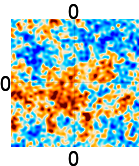

0.2637000905838187


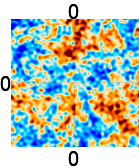

0.2555848803296015


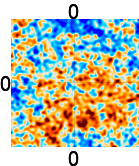

0.25203618352914775


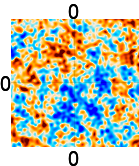

0.2451684385200526


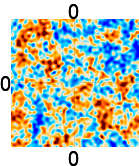

In [27]:
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_logzshrink_normalization_info_validation.npz"
compts = ["kappa"]
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file, channel_idxes=compts)
SUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file, channel_idxes=compts)

DB = datasets.SehgalDataSet(output_dir, "Gkappa021120", transforms=[SDN], shape=(1,128,128))
nplot = 1
_, wcs = maps.rect_geometry(width_arcmin=64., px_res_arcmin=0.5)
for j in range(5):
    print(np.max(SUN(DB[j].copy())))
    enplot.pshow(enmap.enmap(SUN(DB[j].copy()), wcs))
